In [4]:
import os, sys
import yaml
import itertools
from collections import defaultdict
from pathlib import Path
import glob
# from src.runner import Runner
# from src.eval import Eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
print("seaborn version: " + sns.__version__)

seaborn version: 0.9.0


In [53]:
outputs_dir = "/data/jeff-law/projects/2019-04-single-cell/Beeline/outputs/datasets"
datasets = ["Camp2017", "Chu2016", "Nestorowa2016"]
num_genes_list = [100, 500, 1000, 2000, 5000]
algs = ["SINCERITIES", "GRNBOOST2", "PIDC", "PPCOR"]
# algs = ["SCODE", "SCRIBE", "GRISLI"]

In [54]:
# time_df = pd.DataFrame()
# list of tuples. 
alg_times = []
for dataset in datasets:
    for num_genes in num_genes_list:
        for alg in algs:
            time_file_path = "%s/%s/genecutoff-%s/%s/time*.txt" % (
                outputs_dir, dataset, num_genes, alg)
            time_files = glob.glob(time_file_path)
            if len(time_files) > 1:
                print("WARNING: more than one time file. Using the first one")
                print(time_files)
            elif len(time_files) < 1:
                print("No time file found for %s, %s, %s. Skipping %s" % (
                    dataset, num_genes, alg, time_file_path))
                continue
            alg_mem = -1
            alg_time = -1
            print(time_files[0])
            with open(time_files[0], 'r') as f:
                for line in f:
                    try:
                        key, val = line.rstrip().split(': ')
                        if 'User time' in key:
                            alg_time = float(val)
                        elif 'Maximum resident' in key:
                            alg_mem = float(val)
                    except ValueError:
                        print("Failed to parse. Line:")
                        print(line)
                        break
            alg_times.append((dataset, num_genes, alg, alg_time, alg_mem))
df = pd.DataFrame(alg_times, columns=["dataset", "num_genes", "alg", "alg_time", "alg_mem"])
# replace -1 with nan
df.replace(-1,np.nan, inplace=True)
# divide the memory by 1000 to get it in megabytes
df['alg_mem'] = df['alg_mem'].apply(lambda x: x/1000.0)
df.head()

/data/jeff-law/projects/2019-04-single-cell/Beeline/outputs/datasets/Camp2017/genecutoff-100/SINCERITIES/time0.txt
/data/jeff-law/projects/2019-04-single-cell/Beeline/outputs/datasets/Camp2017/genecutoff-100/GRNBOOST2/time.txt
/data/jeff-law/projects/2019-04-single-cell/Beeline/outputs/datasets/Camp2017/genecutoff-100/PIDC/time.txt
/data/jeff-law/projects/2019-04-single-cell/Beeline/outputs/datasets/Camp2017/genecutoff-100/PPCOR/time.txt
/data/jeff-law/projects/2019-04-single-cell/Beeline/outputs/datasets/Camp2017/genecutoff-500/SINCERITIES/time0.txt
/data/jeff-law/projects/2019-04-single-cell/Beeline/outputs/datasets/Camp2017/genecutoff-500/GRNBOOST2/time.txt
/data/jeff-law/projects/2019-04-single-cell/Beeline/outputs/datasets/Camp2017/genecutoff-500/PIDC/time.txt
/data/jeff-law/projects/2019-04-single-cell/Beeline/outputs/datasets/Camp2017/genecutoff-500/PPCOR/time.txt
/data/jeff-law/projects/2019-04-single-cell/Beeline/outputs/datasets/Camp2017/genecutoff-1000/SINCERITIES/time0.txt


,dataset,num_genes,alg,alg_time,alg_mem
0,Camp2017,100,SINCERITIES,20.62,228.200
1,Camp2017,100,GRNBOOST2,70.03,211.660
2,Camp2017,100,PIDC,24.20,309.024
3,Camp2017,100,PPCOR,0.47,69.004
4,Camp2017,500,SINCERITIES,160.52,268.460


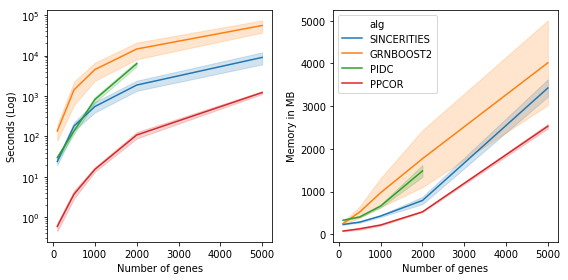

In [55]:
# now plot the time and memory usage
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))
sns.lineplot(x="num_genes", y="alg_time", hue='alg', data=df, ax=ax1,
             ci='sd', estimator=np.median, legend=False)
ax1.set_yscale('log')
ax1.set_ylabel("Seconds (Log)")
ax1.set_xlabel("Number of genes")

sns.lineplot(x="num_genes", y="alg_mem", hue='alg', data=df, ax=ax2,
             ci='sd', estimator=np.median)
ax2.set_ylabel("Memory in MB")
ax2.set_xlabel("Number of genes")

plt.tight_layout()
plt.show()

In [23]:
df[df['alg'] == "PIDC"]

,dataset,num_genes,alg,alg_time,alg_mem
2,Camp2017,100,PIDC,24.20,309024.0
6,Camp2017,500,PIDC,108.12,391160.0
10,Camp2017,1000,PIDC,594.39,605080.0
14,Camp2017,2000,PIDC,4903.68,1385096.0
18,Camp2017,5000,PIDC,NaN,NaN
22,Chu2016,100,PIDC,29.80,328232.0
26,Chu2016,500,PIDC,135.77,405140.0
30,Chu2016,1000,PIDC,820.39,660104.0
34,Chu2016,2000,PIDC,6320.98,1481816.0
38,Chu2016,5000,PIDC,NaN,NaN


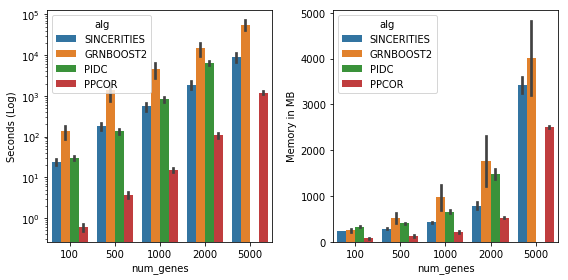

In [38]:
# now plot the time and memory usage
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))
sns.barplot(x="num_genes", y="alg_time", hue='alg', data=df, ax=ax1,
             ci='sd', estimator=np.median)
ax1.set_yscale('log')
ax1.set_ylabel("Seconds (Log)")
ax.set_xlabel("Number of genes")

sns.barplot(x="num_genes", y="alg_mem", hue='alg', data=df, ax=ax2,
             ci='sd', estimator=np.median)
ax2.set_ylabel("Memory in MB")
ax.set_xlabel("Number of genes")

plt.tight_layout()
plt.show()

In [48]:
df = pd.DataFrame([["1","2","3"],['a','b','c']])
df
df2 = df.copy()
df2.columns = ['a','b','c']
pd.concat([df, df2])

,0,1,2,a,b,c
0,1,2,3,NaN,NaN,NaN
1,a,b,c,NaN,NaN,NaN
0,NaN,NaN,NaN,1,2,3
1,NaN,NaN,NaN,a,b,c


In [50]:
edges = df[0] + '-' + df[1]

In [52]:
edges.values

array(['1-2', 'a-b'], dtype=object)